# Putting it all together with sentiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import pdb
from alpha_vantage.timeseries import TimeSeries

In [2]:
stocks = ['NFLX', 'ADBE', 'ADM', 'AEO', 'ALL']

In [3]:
# get sentiment data and dates for the stocks in dictionaries
sentfile = pd.read_csv('SentdexSentiment.csv',index_col=0,header=None)
sentfile.columns = ['stock','sentiment']
sentdict = {}
sentdatesdict = {}
for x in stocks:
    temp = sentfile.loc[sentfile['stock'] == x]
    temp1 = temp['sentiment'].tolist()
    temp2 = temp.index.values.tolist()
    sentdict['{0}'.format(x)]=temp1
    sentdatesdict['{0}'.format(x)]=temp2

In [4]:
# getting the close data and dates from the stocks above
def getstockdata(stocks, sentdatesdict):
    mydict_dates={}
    mydict_close={}
    for x in stocks:
        ts = TimeSeries(key='MAINUT5068DCQGJ9',output_format='pandas')
        mydata, meta_data = ts.get_daily(x,outputsize='full')
        begin = sentdatesdict[x][0]
        end = sentdatesdict[x][-1]
        temp = mydata.loc[begin:end]
        temp1 = temp['4. close'].tolist()
        temp2 = temp.index.values.tolist()
        mydict_close['{0}'.format(x)]=temp1
        mydict_dates['{0}'.format(x)]=temp2
    return mydict_dates, mydict_close

In [5]:
mydates, myclose = getstockdata(stocks,sentdatesdict)

In [6]:
def datearrangement(sentdates,sent,closedates,close):
    newdatedict = {}
    newsentdict = {}
    newclosedict = {}
    for x in stocks:
        #pdb.set_trace()
        datelist1 = sentdates[x]
        datelist2 = closedates[x]
        sentlist = sent[x]
        closelist = close[x]
        if len(datelist1) > len(datelist2):
            shortlength = len(datelist2)
        else:
            shortlength = len(datelist1)
        i = j = 0
        while i < shortlength and j < shortlength:
            if datelist1[i] == datelist2[j]:
                i = i+1
                j = j+1
            elif datelist1[i] < datelist2[j]:
                del datelist1[i]
                del sentlist[i]
            elif datelist1[i] > datelist2[j]:
                del datelist2[j]
                del closelist[j]
        while len(datelist1) > len(datelist2):
            del datelist1[-1]
            del sentlist[-1]
        newdatedict[x] = datelist1
        newsentdict[x] = sentlist
        newclosedict[x] = closelist
    return newdatedict, newsentdict, newclosedict

In [7]:
dict_date, dict_sent, dict_close = datearrangement(sentdatesdict, sentdict, mydates, myclose)

In [ ]:
###### not used ######
def preprocessing(datadic):
    # choosing different preprocessing tools
    preproc = input("What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): ")
    print("You chose: ", preproc)
    if preproc == 'D':
        for key,value in datadic.items():
            #pdb.set_trace()
            print(type(value))
            temp = np.asarray(value)
            print(type(temp))
            temp = np.diff(temp)
            value = temp.tolist()
        print('Differencing applied')
    elif preproc == 'M':
        for key,value in datadic.items():
            cumsum = np.cumsum(np.insert(value, 0, 0)) 
            value = (cumsum[5:] - cumsum[:-5]) / float(5)
        print('Moving Average applied')
    else:
        print('no preprocessing applied')
    return datadic

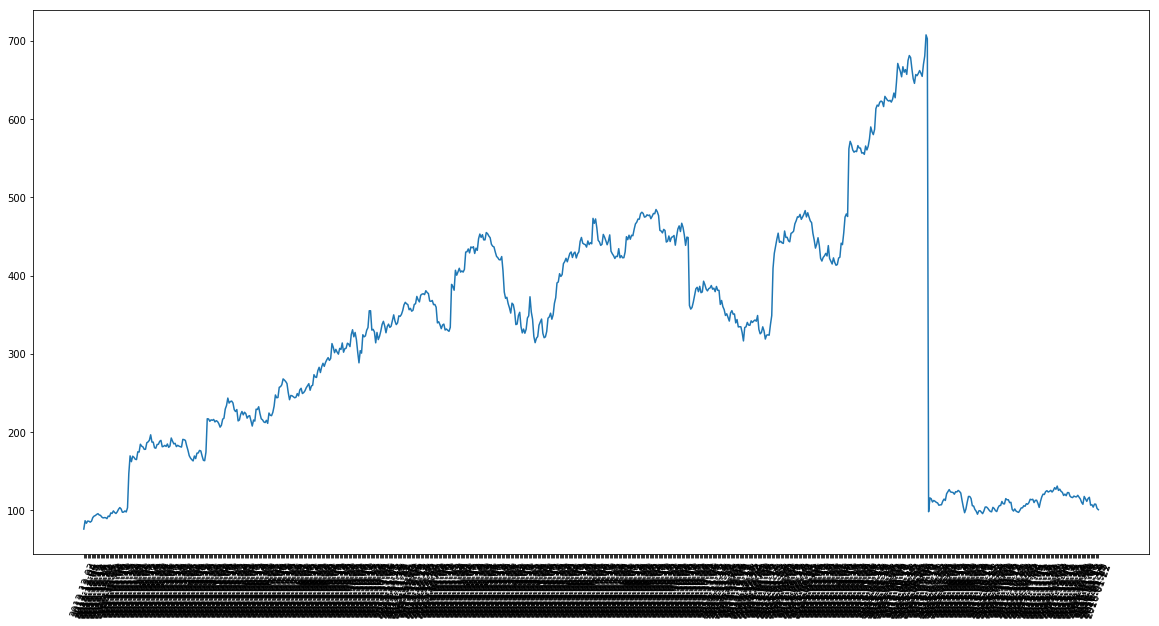

In [8]:
# plotting one dataset for fun
plt.figure(figsize=(20,10))
plt.plot(dict_date['NFLX'],dict_close['NFLX'])
plt.xticks(rotation=70)
plt.show()

In [11]:
# split in training, validation and test set
def splitting(mydic,sentdic):
    ctrain_dic = {}
    cval_dic ={}
    ctest_dic = {}
    strain_dic = {}
    sval_dic ={}
    stest_dic = {}
    for x in stocks:
        dataset = mydic[x]
        sentset = sentdic[x]
        train_size = int(len(dataset) * 0.6)
        val_size = int(len(dataset) * 0.2)
        test_size = len(dataset) - train_size - val_size
        ctrain, cval, ctest = dataset[0:train_size], dataset[train_size:train_size+val_size], dataset[train_size+val_size:len(dataset)]
        ctrain_dic[x] = ctrain
        cval_dic[x] = cval
        ctest_dic[x] = ctest
        strain, sval, stest = sentset[0:train_size], sentset[train_size:train_size+val_size], sentset[train_size+val_size:len(dataset)]
        strain_dic[x] = strain
        sval_dic[x] = sval
        stest_dic[x] = stest
    return ctrain_dic, cval_dic, ctest_dic, strain_dic, sval_dic, stest_dic

In [12]:
train_dic, val_dic, test_dic, strain_dic, sval_dic, stest_dic = splitting(dict_close,dict_sent)

In [16]:
len(strain_dic['NFLX'])

474

In [30]:
def create_dataset(dataset,sentset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)] + sentset[i:(i+look_back)]
        #b = sentset[i:(i+look_back)]
        dataX.append(a)
        #dataX.append(b)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [35]:
look_back = input("How many days in the past do you want to use as feature vector? ")
print("You chose: ", look_back)
look_back = int(look_back)

How many days in the past do you want to use as feature vector? 3
You chose:  3


In [36]:
def dictdatasets(mydict, sentdict, look_back):
    X_dict = {}
    Y_dict = {}
    #pdb.set_trace()
    for x in stocks:
        dataset = mydict[x]
        sentset = sentdict[x]
        Xdata, Ydata = create_dataset(dataset,sentset, look_back)
        X_dict[x] = Xdata
        Y_dict[x] = Ydata
    return X_dict, Y_dict


In [37]:
trainXdict, trainYdict = dictdatasets(train_dic,strain_dic, look_back)
valXdict, valYdict = dictdatasets(val_dic,sval_dic, look_back)
testXdict, testYdict = dictdatasets(test_dic,stest_dic, look_back)

In [39]:
print(trainYdict)

{'NFLX': array([  86.17  ,   85.98  ,   84.8   ,   86.0837,   90.7295,   92.56  ,
         93.3   ,   94.7   ,   95.6408,   93.9785,   93.5   ,   91.34  ,
         90.23  ,   90.65  ,   90.5   ,   89.33  ,   92.59  ,   92.01  ,
         96.59  ,   95.98  ,   99.2004,   97.1563,   95.91  ,   98.    ,
        101.29  ,  103.445 ,  101.69  ,   97.48  ,   97.7   ,   99.17  ,
         97.81  ,  103.26  ,  146.86  ,  169.56  ,  162.11  ,  169.12  ,
        167.7   ,  165.24  ,  164.8   ,  174.74  ,  174.387 ,  184.41  ,
        181.962 ,  180.97  ,  177.89  ,  177.95  ,  186.269 ,  187.4   ,
        189.512 ,  196.45  ,  187.12  ,  187.15  ,  179.86  ,  179.32  ,
        184.09  ,  184.32  ,  188.08  ,  189.37  ,  181.21  ,  181.73  ,
        182.94  ,  181.56  ,  184.7   ,  180.45  ,  182.11  ,  192.36  ,
        188.37  ,  184.85  ,  185.59  ,  181.37  ,  183.05  ,  181.99  ,
        181.3   ,  180.79  ,  190.61  ,  190.24  ,  189.28  ,  182.43  ,
        176.69  ,  169.74  ,  166.69  ,  1

# ML methods to use:
Decision Trees<br>
MLP - Multilayer Perceptron Regressor<br>
SVR - Support Vector Regression<br>
NNR - Nearest Neighbor Regression

In [40]:
# import the needed libraries
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

In [41]:
treeclass = tree.DecisionTreeRegressor()
MLPclass = MLPClassifier(hidden_layer_sizes=(30,30,30),max_iter=10000)
SVRclass = SVR(C=1.0, epsilon=0.2)
neighclass = KNeighborsRegressor(n_neighbors=2)

# Train on one stock - use for one stock

In [42]:
## choose stock
stocknbr = input("Choose one number for one of the stocks above (starting from 0) ")
stocknbr = int(stocknbr)
print("You chose: ", stocks[stocknbr])

Choose one number for one of the stocks above (starting from 0) 1
You chose:  ADBE


In [43]:
train1X = trainXdict[stocks[stocknbr]]
train1Y = trainYdict[stocks[stocknbr]]
val1X = valXdict[stocks[stocknbr]]
val1Y = valYdict[stocks[stocknbr]]
test1X = testXdict[stocks[stocknbr]]
test1Y = testYdict[stocks[stocknbr]]
dataset = myclose[stocks[stocknbr]]
thedates = mydates[stocks[stocknbr]]

In [44]:
scaler = StandardScaler()
scaler.fit(train1X)
train1X_MLP = scaler.transform(train1X.astype('|S6'))
train1Y_MLP = train1Y.astype('|S6')
val1X_MLP = scaler.transform(val1X.astype('|S6'))
test1X_MLP = scaler.transform(test1X.astype('|S6'))

/Users/beate/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype |S6 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [45]:
# train the classifiers on the training data
treeclass = treeclass.fit(train1X, train1Y)
MLPclass.fit(train1X_MLP,train1Y_MLP)
SVRclass = SVRclass.fit(train1X, train1Y)
neighclass.fit(train1X, train1Y) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [46]:
# do predictions for all classifiers
tree_trainPredict = treeclass.predict(train1X)
tree_valPredict = treeclass.predict(val1X)
tree_testPredict = treeclass.predict(test1X)

MLP_trainPredict = MLPclass.predict(train1X_MLP)
MLP_valPredict = MLPclass.predict(val1X_MLP)
MLP_testPredict = MLPclass.predict(test1X_MLP)

SVR_trainPredict = SVRclass.predict(train1X)
SVR_valPredict = SVRclass.predict(val1X)
SVR_testPredict = SVRclass.predict(test1X)

neigh_trainPredict = neighclass.predict(train1X)
neigh_valPredict = neighclass.predict(val1X)
neigh_testPredict = neighclass.predict(test1X)

In [47]:
tree_trainScore = np.sqrt(mean_squared_error(train1Y, tree_trainPredict))
tree_valScore = np.sqrt(mean_squared_error(val1Y, tree_valPredict))
tree_testScore = np.sqrt(mean_squared_error(test1Y, tree_testPredict))
print('Tree Train Score: %.2f RMSE' % (tree_trainScore))
print('Tree Val Score: %.2f RMSE' % (tree_valScore))
print('Tree Test Score: %.2f RMSE' % (tree_testScore))

MLP_trainScore = np.sqrt(mean_squared_error(train1Y, MLP_trainPredict.astype('float32')))
MLP_valScore = np.sqrt(mean_squared_error(val1Y, MLP_valPredict.astype('float32')))
MLP_testScore = np.sqrt(mean_squared_error(test1Y, MLP_testPredict.astype('float32')))
print('Tree Train Score: %.2f RMSE' % (MLP_trainScore))
print('Tree Val Score: %.2f RMSE' % (MLP_valScore))
print('Tree Test Score: %.2f RMSE' % (MLP_testScore))

SVR_trainScore = np.sqrt(mean_squared_error(train1Y, SVR_trainPredict))
SVR_valScore = np.sqrt(mean_squared_error(val1Y, SVR_valPredict))
SVR_testScore = np.sqrt(mean_squared_error(test1Y, SVR_testPredict))
print('SVR Train Score: %.2f RMSE' % (SVR_trainScore))
print('SVR Val Score: %.2f RMSE' % (SVR_valScore))
print('SVR Test Score: %.2f RMSE' % (SVR_testScore))

neigh_trainScore = np.sqrt(mean_squared_error(train1Y, neigh_trainPredict))
neigh_valScore = np.sqrt(mean_squared_error(val1Y, neigh_valPredict))
neigh_testScore = np.sqrt(mean_squared_error(test1Y, neigh_testPredict))
print('neigh Train Score: %.2f RMSE' % (neigh_trainScore))
print('neigh Val Score: %.2f RMSE' % (neigh_valScore))
print('neigh Test Score: %.2f RMSE' % (neigh_testScore))

Tree Train Score: 0.00 RMSE
Tree Val Score: 5.05 RMSE
Tree Test Score: 15.49 RMSE
Tree Train Score: 1.20 RMSE
Tree Val Score: 5.60 RMSE
Tree Test Score: 16.78 RMSE
SVR Train Score: 5.14 RMSE
SVR Val Score: 17.65 RMSE
SVR Test Score: 29.26 RMSE
neigh Train Score: 0.70 RMSE
neigh Val Score: 4.25 RMSE
neigh Test Score: 14.29 RMSE


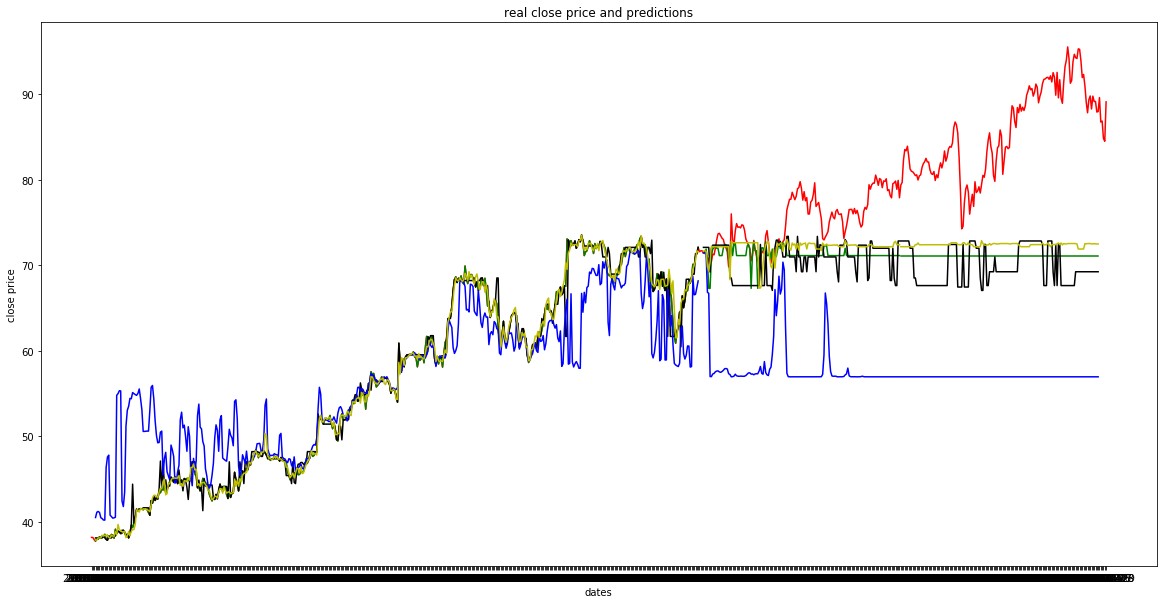

In [48]:
# shift train predictions for plotting
treetrainPredictPlot = np.empty_like(dataset)
treetrainPredictPlot[:] = np.nan
treetrainPredictPlot[look_back:len(tree_trainPredict)+look_back] = tree_trainPredict[:]

MLPtrainPredictPlot = np.empty_like(dataset)
MLPtrainPredictPlot[:] = np.nan
MLPtrainPredictPlot[look_back:len(MLP_trainPredict)+look_back] = MLP_trainPredict[:]

SVRtrainPredictPlot = np.empty_like(dataset)
SVRtrainPredictPlot[:] = np.nan
SVRtrainPredictPlot[look_back:len(SVR_trainPredict)+look_back] = SVR_trainPredict[:]

neightrainPredictPlot = np.empty_like(dataset)
neightrainPredictPlot[:] = np.nan
neightrainPredictPlot[look_back:len(neigh_trainPredict)+look_back] = neigh_trainPredict[:]

# shift val predictions for plotting
treevalPredictPlot = np.empty_like(dataset)
treevalPredictPlot[:] = np.nan
treevalPredictPlot[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)] = tree_valPredict[:]

MLPvalPredictPlot = np.empty_like(dataset)
MLPvalPredictPlot[:] = np.nan
MLPvalPredictPlot[len(MLP_trainPredict)+(look_back*2):len(MLP_trainPredict)+len(MLP_valPredict)+(look_back*2)] = MLP_valPredict[:]

SVRvalPredictPlot = np.empty_like(dataset)
SVRvalPredictPlot[:] = np.nan
SVRvalPredictPlot[len(SVR_trainPredict)+(look_back*2):len(SVR_trainPredict)+len(SVR_valPredict)+(look_back*2)] = SVR_valPredict[:]

neighvalPredictPlot = np.empty_like(dataset)
neighvalPredictPlot[:] = np.nan
neighvalPredictPlot[len(neigh_trainPredict)+(look_back*2):len(neigh_trainPredict)+len(neigh_valPredict)+(look_back*2)] = neigh_valPredict[:]

# shift test prediction for plotting

treetestPredictPlot = np.empty_like(dataset)
treetestPredictPlot[:] = np.nan
treetestPredictPlot[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)] = tree_testPredict[:]

MLPtestPredictPlot = np.empty_like(dataset)
MLPtestPredictPlot[:] = np.nan
MLPtestPredictPlot[len(MLP_trainPredict)+len(MLP_valPredict)+(look_back*2):len(MLP_trainPredict)+len(MLP_valPredict)+len(MLP_testPredict)+(look_back*2)] = MLP_testPredict[:]

SVRtestPredictPlot = np.empty_like(dataset)
SVRtestPredictPlot[:] = np.nan
SVRtestPredictPlot[len(SVR_trainPredict)+len(SVR_valPredict)+(look_back*2):len(SVR_trainPredict)+len(SVR_valPredict)+len(SVR_testPredict)+(look_back*2)] = SVR_testPredict[:]

neightestPredictPlot = np.empty_like(dataset)
neightestPredictPlot[:] = np.nan
neightestPredictPlot[len(neigh_trainPredict)+len(neigh_valPredict)+(look_back*2):len(neigh_trainPredict)+len(neigh_valPredict)+len(neigh_testPredict)+(look_back*2)] = neigh_testPredict[:]

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(thedates,dataset,'r')
plt.plot(thedates,treetrainPredictPlot,'g')
plt.plot(thedates,treevalPredictPlot,'g')
plt.plot(thedates,treetestPredictPlot,'g')
plt.plot(thedates,MLPtrainPredictPlot,'k')
plt.plot(thedates,MLPvalPredictPlot,'k')
plt.plot(thedates,MLPtestPredictPlot,'k')
plt.plot(thedates,SVRtrainPredictPlot,'b')
plt.plot(thedates,SVRvalPredictPlot,'b')
plt.plot(thedates,SVRtestPredictPlot,'b')
plt.plot(thedates,neightrainPredictPlot,'y')
plt.plot(thedates,neighvalPredictPlot,'y')
plt.plot(thedates,neightestPredictPlot,'y')
plt.ylabel('close price')
plt.xlabel('dates')
plt.title('real close price and predictions')
plt.show()

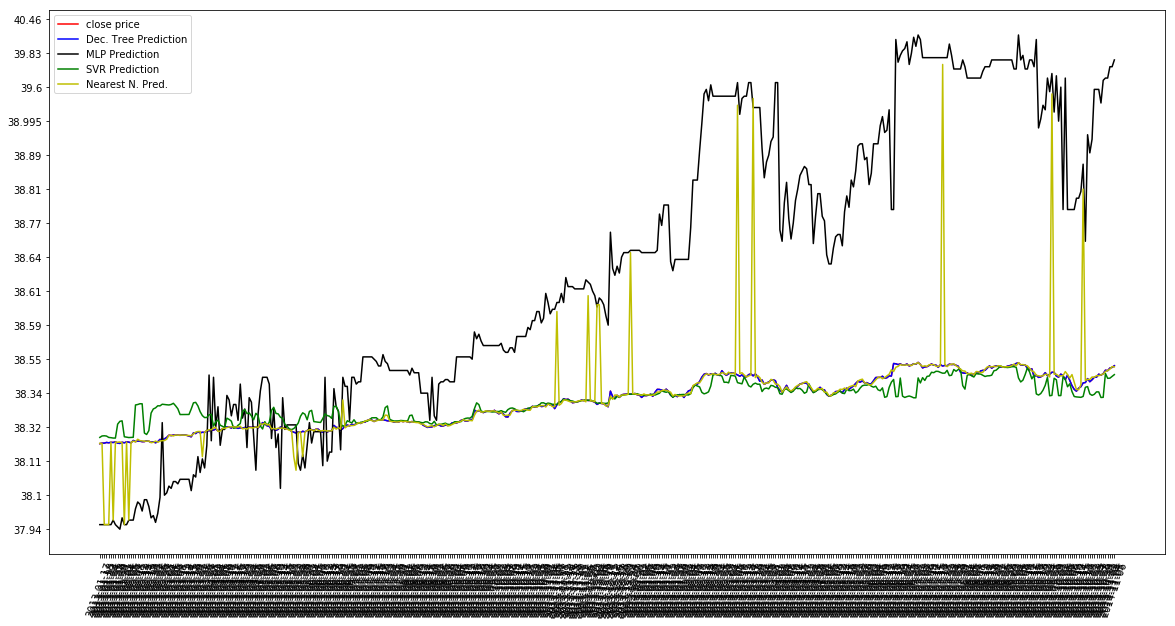

In [49]:
# plot only training
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[look_back:len(tree_trainPredict)+look_back]
datachunk = dataset[look_back:len(tree_trainPredict)+look_back]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_trainPredict,'b')
plt.plot(datechunk,MLP_trainPredict,'k')
plt.plot(datechunk,SVR_trainPredict,'g')
plt.plot(datechunk,neigh_trainPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('training_from1stock.eps', format='eps', dpi=1000)

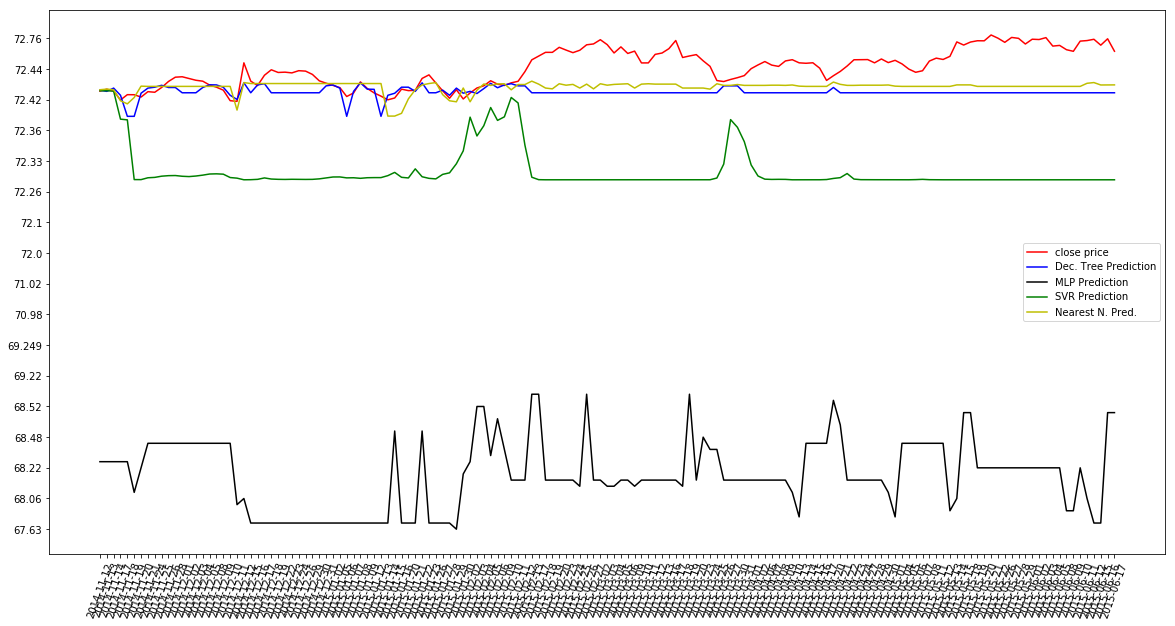

In [50]:
# plot only val
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)]
datachunk = dataset[len(tree_trainPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+(look_back*2)]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_valPredict,'b')
plt.plot(datechunk,MLP_valPredict,'k')
plt.plot(datechunk,SVR_valPredict,'g')
plt.plot(datechunk,neigh_valPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('val_from1stock.eps', format='eps', dpi=1000)

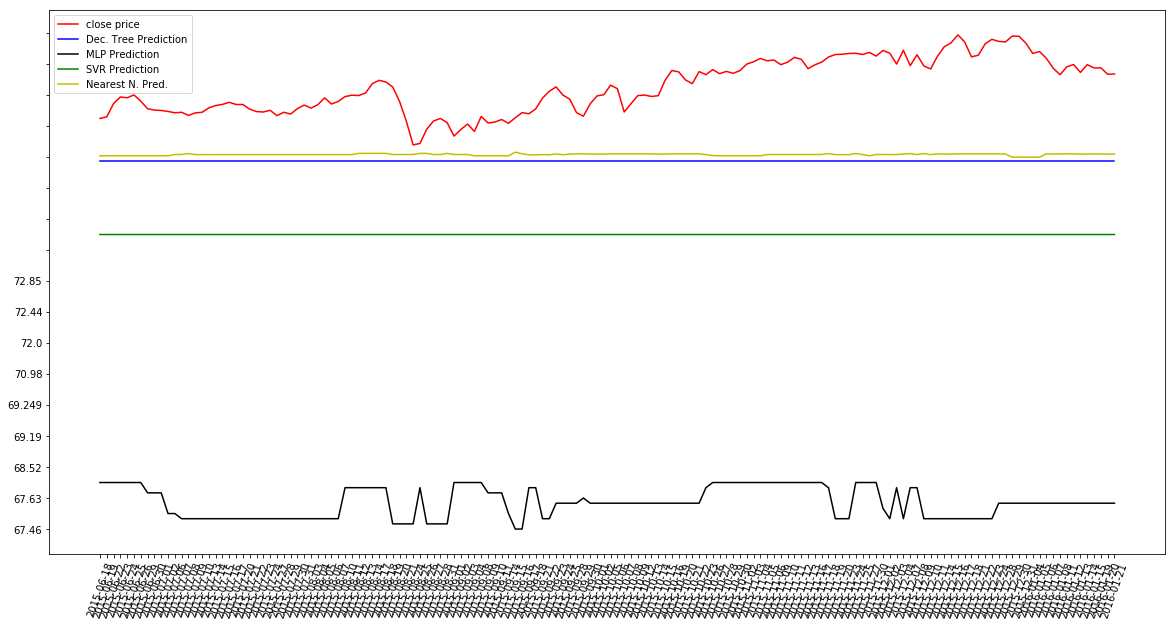

In [51]:
# plot only test
beingsaved = plt.figure(figsize=(20,10))
ax = plt.axes()

datechunk = thedates[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)]
datachunk = dataset[len(tree_trainPredict)+len(tree_valPredict)+(look_back*2):len(tree_trainPredict)+len(tree_valPredict)+len(tree_testPredict)+(look_back*2)]
plt.plot(datechunk,datachunk,'r')
plt.plot(datechunk,tree_testPredict,'b')
plt.plot(datechunk,MLP_testPredict,'k')
plt.plot(datechunk,SVR_testPredict,'g')
plt.plot(datechunk,neigh_testPredict,'y')
#plt.xticks(datechunk[1:len(datechunk):500], rotation=70)
plt.xticks(rotation=70)
plt.legend(['close price','Dec. Tree Prediction','MLP Prediction','SVR Prediction','Nearest N. Pred.'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
beingsaved.savefig('test_from1stock.eps', format='eps', dpi=1000)